In [1]:
import jtap_mice
jtap_mice.set_jaxcache()
from jtap_mice.inference import run_jtap, run_parallel_jtap, JTAPMiceData
from jtap_mice.viz import rerun_jtap_stimulus, animate_jtap_mice_predictions, jtap_plot_lr_lines, plot_proposal_direction_outlier_pdf, draw_stimulus_image
from jtap_mice.utils import load_left_right_stimulus, JTAPMiceStimulus, ChexModelInput, d2r, i_, f_, slice_pt, init_step_concat, discrete_obs_to_rgb, stack_pytrees, concat_pytrees
from jtap_mice.evaluation import jtap_compute_beliefs, JTAPMice_Beliefs

import time
import rerun as rr
import genjax
from genjax import gen, ChoiceMapBuilder as C
import jax
import jax.numpy as jnp
from jax.debug import print as jprint
import numpy as np
from tqdm import tqdm
import jax.tree_util as jtu
from functools import partial
from matplotlib import pyplot as plt
from typing import List, Dict, Any, Tuple, NamedTuple

PIXEL_DENSITY = 10
SKIP_T = 4

In [2]:
LR_CONFIG= 'lr_v1'
LR_TRIAL = 1

stimulus_path = f'{LR_CONFIG}.json'

# jtap_stimulus = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY, skip_t = SKIP_T, trial_number = LR_TRIAL, inject_occlusion = [[3.4, 2.7]])
jtap_stimulus = load_left_right_stimulus(stimulus_path, pixel_density = PIXEL_DENSITY, skip_t = SKIP_T, trial_number = LR_TRIAL, inject_occlusion = None)

In [ ]:
rerun_jtap_stimulus(discrete_obs = jtap_stimulus.discrete_obs, stimulus_name = "rg_stim1_discrete")

In [3]:
# Parameters based on default values in ChexModelInput @datastrucs.py

model_direction_flip_prob = 0.025
simulation_direction_flip_prob = 0.005
proposal_direction_flip_prob = 0.005

σ_pos_model=0.5
σ_pos_simulation=0.05
σ_pos_stepprop = 0.01

σ_speed_model=0.075
σ_speed_simulation=0.075
σ_speed_stepprop = 0.01

Model_Input = ChexModelInput(
    model_outlier_prob = 0.00,
    proposal_direction_outlier_tau = d2r(40.),
    proposal_direction_outlier_alpha = 3.5,
    σ_pos_model=σ_pos_model,
    σ_speed_model=σ_speed_model,
    model_direction_flip_prob=model_direction_flip_prob,
    pixel_corruption_prob=0.01,
    tile_size=3,
    σ_pixel_spatial=1.0,
    image_power_beta=0.005,
    max_speed=1.0,
    max_num_occ=5,
    num_x_grid=8,
    grid_size_bounds=(0.05, 0.95),
    simulate_every=1,
    σ_pos_simulation=σ_pos_simulation,
    σ_speed_simulation=σ_speed_simulation,
    simulation_direction_flip_prob=simulation_direction_flip_prob,
    σ_pos_initprop=0.02,
    proposal_direction_flip_prob=proposal_direction_flip_prob,#direction_flip_prob,
    σ_speed_stepprop=σ_speed_stepprop,
    σ_pos_stepprop=σ_pos_stepprop
)
# PREPARE INPUT
Model_Input.prepare_hyperparameters()
Model_Input.prepare_scene_geometry(jtap_stimulus)

ESS_proportion = 0.1
smc_key_seed = np.random.randint(0, 1000000)
num_particles = 30

In [6]:
num_jtap_runs = 50

start_time = time.time()
JTAPMICE_DATA, xx = run_parallel_jtap(num_jtap_runs, smc_key_seed, Model_Input, ESS_proportion, jtap_stimulus, num_particles)
end_time = time.time()
mean_ESS = np.mean(JTAPMICE_DATA.inference.ESS.mean(axis=1))
print(f"Mean ESS: {100 * mean_ESS / num_particles:.1f}% of {num_particles} particles")
resampled = JTAPMICE_DATA.inference.resampled
resampled_pct = 100 * np.mean(resampled)
print(f"Resampling occurred in {resampled_pct:.1f}% of {jtap_stimulus.num_frames} frames")
print(f"Time taken for parallel JTAP: {end_time - start_time} seconds")

Mean ESS: 23.2% of 30 particles
Resampling occurred in 19.0% of 46 frames
Time taken for parallel JTAP: 6.075916051864624 seconds


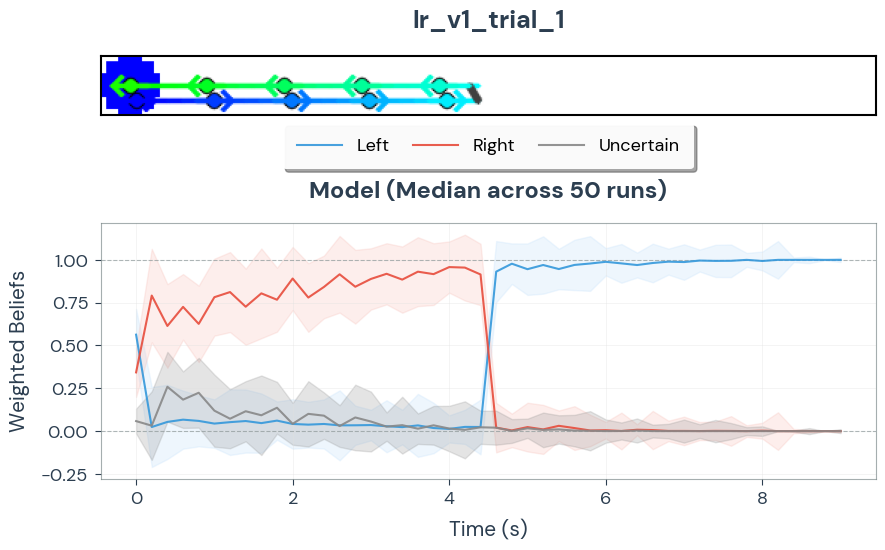

In [7]:
jtap_mice_beliefs = jtap_compute_beliefs(JTAPMICE_DATA)
jtap_run_idx = None
show_all_lines = False
show_std_band = True
jtap_plot_lr_lines(lr_beliefs = jtap_mice_beliefs, stimulus = jtap_stimulus, show = "model", include_baselines=False, remove_legend=False, show_std_band=show_std_band, jtap_run_idx = jtap_run_idx, include_start_frame=True, show_all_beliefs=show_all_lines, plot_stat = "median", include_stimulus=True)

In [8]:
animate_jtap_mice_predictions(
    JTAPMICE_DATA, 
    jtap_run_idx=0,
    scn_dot_size=50, 
    pred_dot_size=50,
    line_thick_min=7,
    line_thick_max=7,
    use_tqdm=True,
    fps=10,
    return_html=True
)

Rendering frames:   0%|          | 0/46 [00:00<?, ?it/s]